# **Word Association and Mutual Information**
## These are features provided in this files..

* ### **Encoding Character Detsets Checking**
* ### **Reading the Dataset (Dataset-CalheirosMoroRita-2017.csv)**
* ### **Cleaning Text Data (LowerText, Tokenize, UseLessWord-Remove, StopWord-Remove, PartOfSpeech, Lemmatize)**
* ### **Vader Lexicon (Positive, Negatives, Compound)**
* ### **Add the number of Characters and Words**
* ### **Gensim Module Vectors (Word2Vec, Doc2Vec)**
* ### **TF-IDF (Term Frequency - Inverse Document Frequency)**
* ### **Word Clouds**
* ## **Interpreting Mutual Information Scores**
* ### **Correlation-Matrix with Heatmap**
* ### **Bar Plot**


In [ ]:
from pandas import read_csv
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from gensim.test.utils import common_texts
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import mutual_info_regression
from wordcloud import WordCloud

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

import nltk
import numpy as np
import pandas as pd
import seaborn as sns

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [ ]:
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


# **Encoding Character Detsets Checking**

In [ ]:
import chardet
file = 'dataset-CalheirosMoroRita-2017.csv'
with open(file, 'rb') as rawdata:
    result = chardet.detect(rawdata.read(100000))
result

{'confidence': 0.73, 'encoding': 'Windows-1252', 'language': ''}

# **Reading the Dataset (Dataset-CalheirosMoroRita-2017.csv)**

In [ ]:
datasets = read_csv('dataset-CalheirosMoroRita-2017.csv', sep='\t', encoding="Windows-1252")
datasets.head(10)

,Review
0,"Everything from the weather, staff, food, pro..."
1,"The hotel it is fantastic built by the sea, li..."
2,One dream! Cozy and comfortable Hotel! The b...
3,Hotel concept is hard to grasp. They communica...
4,"This is a wonderful hotel, for a romantic esca..."
5,Gold room fantastic. We loved and we will come...
6,"One of the best Hotels in the world, and in th..."
7,"Land Room is wonderful! An amazing place, as ..."
8,One of the greatest meals ever. Everything wa...
9,"A peaceful place, built with a lot of tas..."


# **Cleaning Text Data (LowerText, Tokenize, UseLessWord-Remove, StopWord-Remove, PartOfSpeech, Lemmatize)**

## To clean textual data, we call our custom 'clean_text' function that performs several transformations:

* lower the text
* tokenize the text (split the text into words) and remove the punctuation
* remove useless words that contain numbers
* remove useless stop words like 'the', 'a' ,'this' etc.
* Part-Of-Speech (POS) tagging: assign a tag to every word to define if it corresponds to a noun, a verb etc. using the WordNet lexical database
* lemmatize the text: transform every word into their root form (e.g. rooms -> room, slept -> sleep)

### Now that we have cleaned our data, we can do some feature engineering for our modelization part.

In [ ]:
# return the wordnet object value corresponding to the POS tag
from nltk.corpus import wordnet

def get_wordnet_pos(pos_tag):
    if pos_tag.startswith('J'):
        return wordnet.ADJ
    elif pos_tag.startswith('V'):
        return wordnet.VERB
    elif pos_tag.startswith('N'):
        return wordnet.NOUN
    elif pos_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN
    
import string
from nltk import pos_tag
from nltk.tokenize import WhitespaceTokenizer
from nltk.stem import WordNetLemmatizer

def clean_text(text):
    # lower text
    text = text.lower()
    # tokenize text and remove puncutation
    text = [word.strip(string.punctuation) for word in text.split(" ")]
    # remove words that contain numbers
    text = [word for word in text if not any(c.isdigit() for c in word)]
    # remove stop words
    stop = stopwords.words('english')
    text = [x for x in text if x not in stop]
    # remove empty tokens
    text = [t for t in text if len(t) > 0]
    # pos tag text
    pos_tags = pos_tag(text)
    # lemmatize text
    text = [WordNetLemmatizer().lemmatize(t[0], get_wordnet_pos(t[1])) for t in pos_tags]
    # remove words with only one letter
    text = [t for t in text if len(t) > 1]
    # join all
    text = " ".join(text)
    return(text)

# clean text data
datasets["review_clean"] = datasets["Review"].apply(lambda x: clean_text(x))

In [ ]:
datasets

,Review,review_clean
0,"Everything from the weather, staff, food, pro...",everything weather staff food property fire pi...
1,"The hotel it is fantastic built by the sea, li...",hotel fantastic build sea live together nature...
2,One dream! Cozy and comfortable Hotel! The b...,one dream cozy comfortable hotel best personal...
3,Hotel concept is hard to grasp. They communica...,hotel concept hard grasp communicate environme...
4,"This is a wonderful hotel, for a romantic esca...",wonderful hotel romantic escape every room the...
...,...,...
396,"An extraordinary place! Amazing, architec...",extraordinary place amazing architecture home ...
397,What a wonderful place to relax and enjoy...,wonderful place relax enjoy countryside specia...
398,Thank you for the best ever. And the best...,thank best ever best dinner pool view beach pl...
399,As you know we have just returned home after 5...,know return home day areias seixo \nwe would l...


# **Vader Lexicon (Positive, Negatives, Compound)**
### Vader uses a lexicon of words to find which ones are positives or negatives. It also takes into accout the context of the sentences to determine the sentiment scores. For each text, Vader retuns 4 values:
* a neutrality score
* a positivity score
* a negativity score
* an overall score that summarizes the previous scores

In [ ]:
sid = SentimentIntensityAnalyzer()
datasets["sentiments"] = datasets["Review"].apply(lambda x: sid.polarity_scores(x))
datasets = pd.concat([datasets.drop(['sentiments'], axis=1), datasets['sentiments'].apply(pd.Series)], axis=1)

In [ ]:
datasets

,Review,review_clean,neg,neu,pos,compound
0,"Everything from the weather, staff, food, pro...",everything weather staff food property fire pi...,0.125,0.781,0.094,-0.1531
1,"The hotel it is fantastic built by the sea, li...",hotel fantastic build sea live together nature...,0.000,0.680,0.320,0.9432
2,One dream! Cozy and comfortable Hotel! The b...,one dream cozy comfortable hotel best personal...,0.029,0.747,0.224,0.9419
3,Hotel concept is hard to grasp. They communica...,hotel concept hard grasp communicate environme...,0.096,0.685,0.219,0.8978
4,"This is a wonderful hotel, for a romantic esca...",wonderful hotel romantic escape every room the...,0.000,0.742,0.258,0.9401
...,...,...,...,...,...,...
396,"An extraordinary place! Amazing, architec...",extraordinary place amazing architecture home ...,0.000,0.536,0.464,0.8313
397,What a wonderful place to relax and enjoy...,wonderful place relax enjoy countryside specia...,0.000,0.369,0.631,0.9371
398,Thank you for the best ever. And the best...,thank best ever best dinner pool view beach pl...,0.000,0.568,0.432,0.9287
399,As you know we have just returned home after 5...,know return home day areias seixo \nwe would l...,0.018,0.750,0.233,0.9848


# **Add the number of Characters and Words**

In [ ]:
# add number of characters column
datasets["nb_chars"] = datasets["Review"].apply(lambda x: len(x))

# add number of words column
datasets["nb_words"] = datasets["Review"].apply(lambda x: len(x.split(" ")))

In [ ]:
datasets

,Review,review_clean,neg,neu,pos,compound,nb_chars,nb_words
0,"Everything from the weather, staff, food, pro...",everything weather staff food property fire pi...,0.125,0.781,0.094,-0.1531,106,18
1,"The hotel it is fantastic built by the sea, li...",hotel fantastic build sea live together nature...,0.000,0.680,0.320,0.9432,229,37
2,One dream! Cozy and comfortable Hotel! The b...,one dream cozy comfortable hotel best personal...,0.029,0.747,0.224,0.9419,405,72
3,Hotel concept is hard to grasp. They communica...,hotel concept hard grasp communicate environme...,0.096,0.685,0.219,0.8978,424,59
4,"This is a wonderful hotel, for a romantic esca...",wonderful hotel romantic escape every room the...,0.000,0.742,0.258,0.9401,304,54
...,...,...,...,...,...,...,...,...
396,"An extraordinary place! Amazing, architec...",extraordinary place amazing architecture home ...,0.000,0.536,0.464,0.8313,106,24
397,What a wonderful place to relax and enjoy...,wonderful place relax enjoy countryside specia...,0.000,0.369,0.631,0.9371,113,30
398,Thank you for the best ever. And the best...,thank best ever best dinner pool view beach pl...,0.000,0.568,0.432,0.9287,131,37
399,As you know we have just returned home after 5...,know return home day areias seixo \nwe would l...,0.018,0.750,0.233,0.9848,717,148


# **Gensim Module Vectors (Word2Vec, Doc2Vec)**

The module Gensim creates a numerical vector representation of every word in the corpus by using the contexts in which they appear (Word2Vec). This is performed using shallow neural networks. What's interesting is that similar words will have similar representation vectors.

Each text can also be transformed into numerical vectors using the word vectors (Doc2Vec). Same texts will also have similar representations and that is why we can use those vectors as training features.

In [ ]:
# create doc2vec vector columns
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(datasets["review_clean"].apply(lambda x: x.split(" ")))]

# train a Doc2Vec model with our text data
model = Doc2Vec(documents, vector_size=5, window=2, min_count=1, workers=4)

# transform each document into a vector data
doc2vec_df = datasets["review_clean"].apply(lambda x: model.infer_vector(x.split(" "))).apply(pd.Series)
doc2vec_df.columns = ["doc2vec_vector_" + str(x) for x in doc2vec_df.columns]
datasets = pd.concat([datasets, doc2vec_df], axis=1)

In [ ]:
datasets

,Review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,doc2vec_vector_2,doc2vec_vector_3,doc2vec_vector_4
0,"Everything from the weather, staff, food, pro...",everything weather staff food property fire pi...,0.125,0.781,0.094,-0.1531,106,18,0.121347,-0.019640,0.074626,-0.081348,-0.081115
1,"The hotel it is fantastic built by the sea, li...",hotel fantastic build sea live together nature...,0.000,0.680,0.320,0.9432,229,37,0.012829,0.016299,-0.071646,-0.039680,0.091726
2,One dream! Cozy and comfortable Hotel! The b...,one dream cozy comfortable hotel best personal...,0.029,0.747,0.224,0.9419,405,72,0.024912,-0.193482,0.032473,-0.086299,0.015110
3,Hotel concept is hard to grasp. They communica...,hotel concept hard grasp communicate environme...,0.096,0.685,0.219,0.8978,424,59,0.100646,-0.042442,0.018163,0.037504,-0.054717
4,"This is a wonderful hotel, for a romantic esca...",wonderful hotel romantic escape every room the...,0.000,0.742,0.258,0.9401,304,54,-0.036751,0.011651,0.005873,-0.024433,-0.012167
...,...,...,...,...,...,...,...,...,...,...,...,...,...
396,"An extraordinary place! Amazing, architec...",extraordinary place amazing architecture home ...,0.000,0.536,0.464,0.8313,106,24,0.107536,0.011011,0.064760,0.041078,0.029646
397,What a wonderful place to relax and enjoy...,wonderful place relax enjoy countryside specia...,0.000,0.369,0.631,0.9371,113,30,0.018214,0.000354,0.106126,-0.066334,-0.023256
398,Thank you for the best ever. And the best...,thank best ever best dinner pool view beach pl...,0.000,0.568,0.432,0.9287,131,37,-0.019327,-0.095160,-0.085757,0.056359,-0.075967
399,As you know we have just returned home after 5...,know return home day areias seixo \nwe would l...,0.018,0.750,0.233,0.9848,717,148,0.157167,-0.228072,0.074973,-0.102031,0.015858


# **TF-IDF (Term Frequency - Inverse Document Frequency)**
Finally we add the TF-IDF (Term Frequency - Inverse Document Frequency) values for every word and every document.

## The TF-IDF metric solves this problem:

* TF computes the classic number of times the word appears in the text
* IDF computes the relative importance of this word which depends on how many texts the word can be found


In [ ]:
# add tf-idfs columns

tfidf = TfidfVectorizer(min_df = 10)
tfidf_result = tfidf.fit_transform(datasets["review_clean"]).toarray()
tfidf_df = pd.DataFrame(tfidf_result, columns = tfidf.get_feature_names())
tfidf_df.columns = ["word_" + str(x) for x in tfidf_df.columns]
tfidf_df.index = datasets.index
datasets = pd.concat([datasets, tfidf_df], axis=1)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
datasets.head()

,Review,review_clean,neg,neu,pos,compound,nb_chars,nb_words,doc2vec_vector_0,doc2vec_vector_1,...,word_welcome,word_well,word_whole,word_wine,word_wonderful,word_word,word_work,word_world,word_would,word_year
0,"Everything from the weather, staff, food, pro...",everything weather staff food property fire pi...,0.125,0.781,0.094,-0.1531,106,18,0.121347,-0.019640,...,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
1,"The hotel it is fantastic built by the sea, li...",hotel fantastic build sea live together nature...,0.000,0.680,0.320,0.9432,229,37,0.012829,0.016299,...,0.000000,0.255368,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
2,One dream! Cozy and comfortable Hotel! The b...,one dream cozy comfortable hotel best personal...,0.029,0.747,0.224,0.9419,405,72,0.024912,-0.193482,...,0.204087,0.000000,0.0,0.238477,0.000000,0.0,0.0,0.0,0.0,0.0
3,Hotel concept is hard to grasp. They communica...,hotel concept hard grasp communicate environme...,0.096,0.685,0.219,0.8978,424,59,0.100646,-0.042442,...,0.000000,0.212266,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
4,"This is a wonderful hotel, for a romantic esca...",wonderful hotel romantic escape every room the...,0.000,0.742,0.258,0.9401,304,54,-0.036751,0.011651,...,0.000000,0.000000,0.0,0.318016,0.169268,0.0,0.0,0.0,0.0,0.0


In [ ]:
datasets.shape

(401, 198)

# **Word Clouds**

## Now let's print some wordclouds to have a glimpse at what kind of words apear in our reviews:



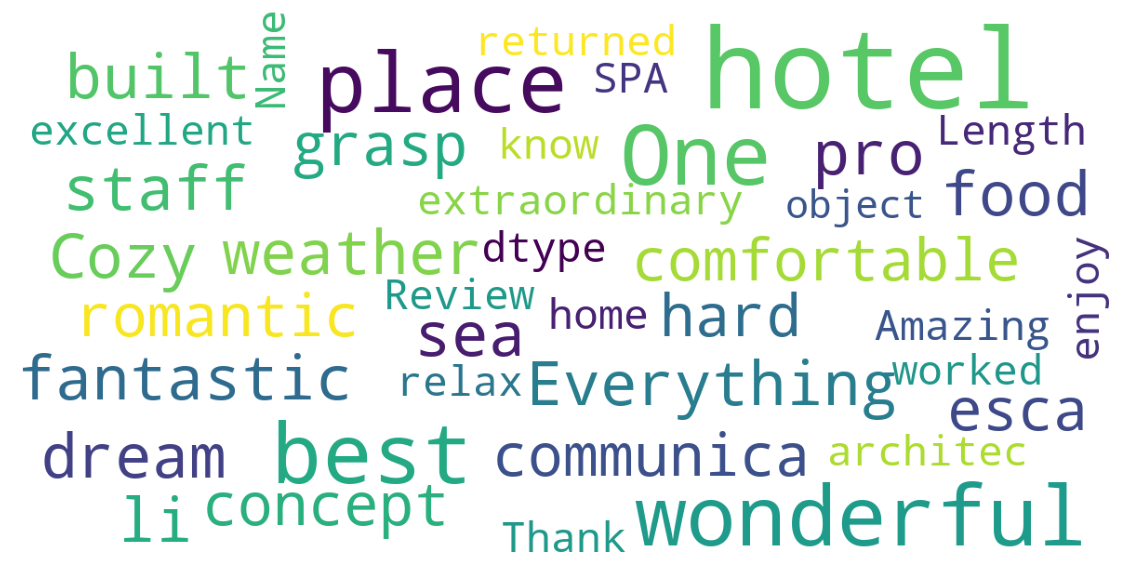

In [ ]:
# wordcloud function
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color = 'white',
        max_words = 200,
        max_font_size = 40, 
        scale = 3,
        random_state = 42
    ).generate(str(data))

    fig = plt.figure(1, figsize = (20, 20))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize = 20)
        fig.subplots_adjust(top = 2.3)

    plt.imshow(wordcloud)
    plt.show()
    
# print wordcloud
show_wordcloud(datasets["Review"])

# **Interpreting Mutual Information Scores**

The scikit-learn algorithm for MI treats discrete features differently from continuous features. Consequently, you need to tell it which are which. As a rule of thumb, anything that must have a float dtype is not discrete. Categoricals (object or categorial dtype) can be treated as discrete by giving them a label encoding. (You can review label encodings in our Categorical Variables lesson.)

In [ ]:
X = datasets.copy()
y = X.pop("compound")

# Label encoding for categoricals
for colname in X.select_dtypes("object"):
    X[colname], _ = X[colname].factorize()

# All discrete features should now have integer dtypes (double-check this before using MI!)
discrete_features = X.dtypes == int


Scikit-learn has two mutual information metrics in its feature_selection module: one for real-valued targets (mutual_info_regression) and one for categorical targets (mutual_info_classif). Our target, price, is real-valued. The next cell computes the MI scores for our features and wraps them up in a nice dataframe.

In [ ]:
def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)

In [ ]:
mi_scores

review_clean     0.950000
Review           0.833333
nb_words         0.373817
nb_chars         0.314281
pos              0.266808
                   ...   
word_course      0.000000
word_cook        0.000000
word_consider    0.000000
word_concept     0.000000
word_year        0.000000
Name: MI Scores, Length: 197, dtype: float64

# **Correlation-Matrix with Heatmap**

## Correlation is a measure of the linear relationship of 2 or more variables. Through correlation, we can predict one variable from the other.

* Good variables are highly correlated with the target.

* Correlated predictor variables provide redundant information.

* Variables should be correlated with the target but uncorrelated among themselves.

* Correlation Feature Selection evaluates subsets of features on the basis of the following hypothesis:

* "Good feature subsets contain features highly correlated with the target, yet uncorrelated to each other".

In [ ]:
# Create correlation matrix
corr_matrix = datasets.corr()
print(corr_matrix)

                 neg       neu       pos  compound  nb_chars  nb_words  \
neg         1.000000  0.250050 -0.412838 -0.451918  0.269783  0.264067   
neu         0.250050  1.000000 -0.985100 -0.288475  0.480340  0.482544   
pos        -0.412838 -0.985100  1.000000  0.351653 -0.499565 -0.500608   
compound   -0.451918 -0.288475  0.351653  1.000000  0.036248  0.035440   
nb_chars    0.269783  0.480340 -0.499565  0.036248  1.000000  0.997267   
...              ...       ...       ...       ...       ...       ...   
word_word   0.177061  0.052747 -0.080912 -0.022210  0.037494  0.031764   
word_work   0.000101  0.090821 -0.085387  0.041785  0.190475  0.192593   
word_world -0.022078  0.133857 -0.121914 -0.038943  0.043701  0.046853   
word_would  0.126611  0.109121 -0.124817  0.058342  0.220513  0.225533   
word_year   0.106983  0.091542 -0.105121 -0.221261  0.157497  0.155355   

            doc2vec_vector_0  doc2vec_vector_1  doc2vec_vector_2  \
neg                 0.278426         -0.223

# **Bar Plot**
And now a bar plot to make comparisions easier:

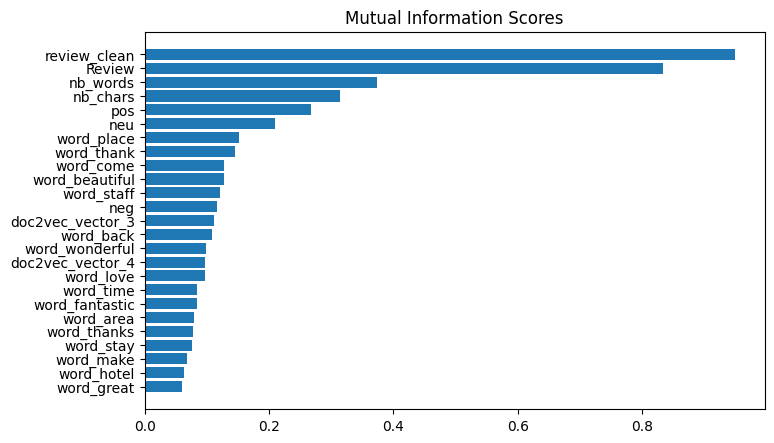

In [ ]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")


plt.figure(dpi=100, figsize=(8, 5))
plot_mi_scores(mi_scores[0:25])

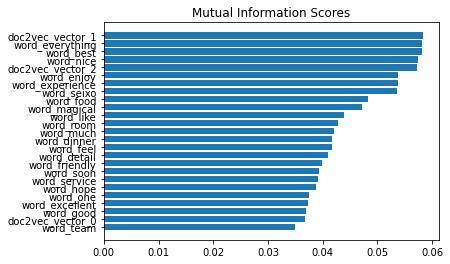

In [ ]:
plot_mi_scores(mi_scores[25:50])